In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

import tensorflow as tf

# 1. Первичный и визуальный анализ данных

In [2]:
from sklearn.datasets import fetch_california_housing

X, y = fetch_california_housing(as_frame=True, return_X_y=True)

X.shape, y.shape

((20640, 8), (20640,))

In [3]:
df = pd.concat([X, y], axis=1)

df.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   MedInc       20640 non-null  float64
 1   HouseAge     20640 non-null  float64
 2   AveRooms     20640 non-null  float64
 3   AveBedrms    20640 non-null  float64
 4   Population   20640 non-null  float64
 5   AveOccup     20640 non-null  float64
 6   Latitude     20640 non-null  float64
 7   Longitude    20640 non-null  float64
 8   MedHouseVal  20640 non-null  float64
dtypes: float64(9)
memory usage: 1.4 MB


In [5]:
df.isna().sum()

MedInc         0
HouseAge       0
AveRooms       0
AveBedrms      0
Population     0
AveOccup       0
Latitude       0
Longitude      0
MedHouseVal    0
dtype: int64

В датасете 9 вещественных признаков и 20640 наблюдений. Пропусков нет. Целевой признак – `MedHouseVal`

In [6]:
df.describe()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
count,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,3.870671,28.639486,5.429000,1.096675,1425.476744,3.070655,35.631861,-119.569704,2.068558
std,1.899822,12.585558,2.474173,0.473911,1132.462122,10.386050,2.135952,2.003532,1.153956
min,0.499900,1.000000,0.846154,0.333333,3.000000,0.692308,32.540000,-124.350000,0.149990
25%,2.563400,18.000000,4.440716,1.006079,787.000000,2.429741,33.930000,-121.800000,1.196000
50%,3.534800,29.000000,5.229129,1.048780,1166.000000,2.818116,34.260000,-118.490000,1.797000
75%,4.743250,37.000000,6.052381,1.099526,1725.000000,3.282261,37.710000,-118.010000,2.647250
max,15.000100,52.000000,141.909091,34.066667,35682.000000,1243.333333,41.950000,-114.310000,5.000010


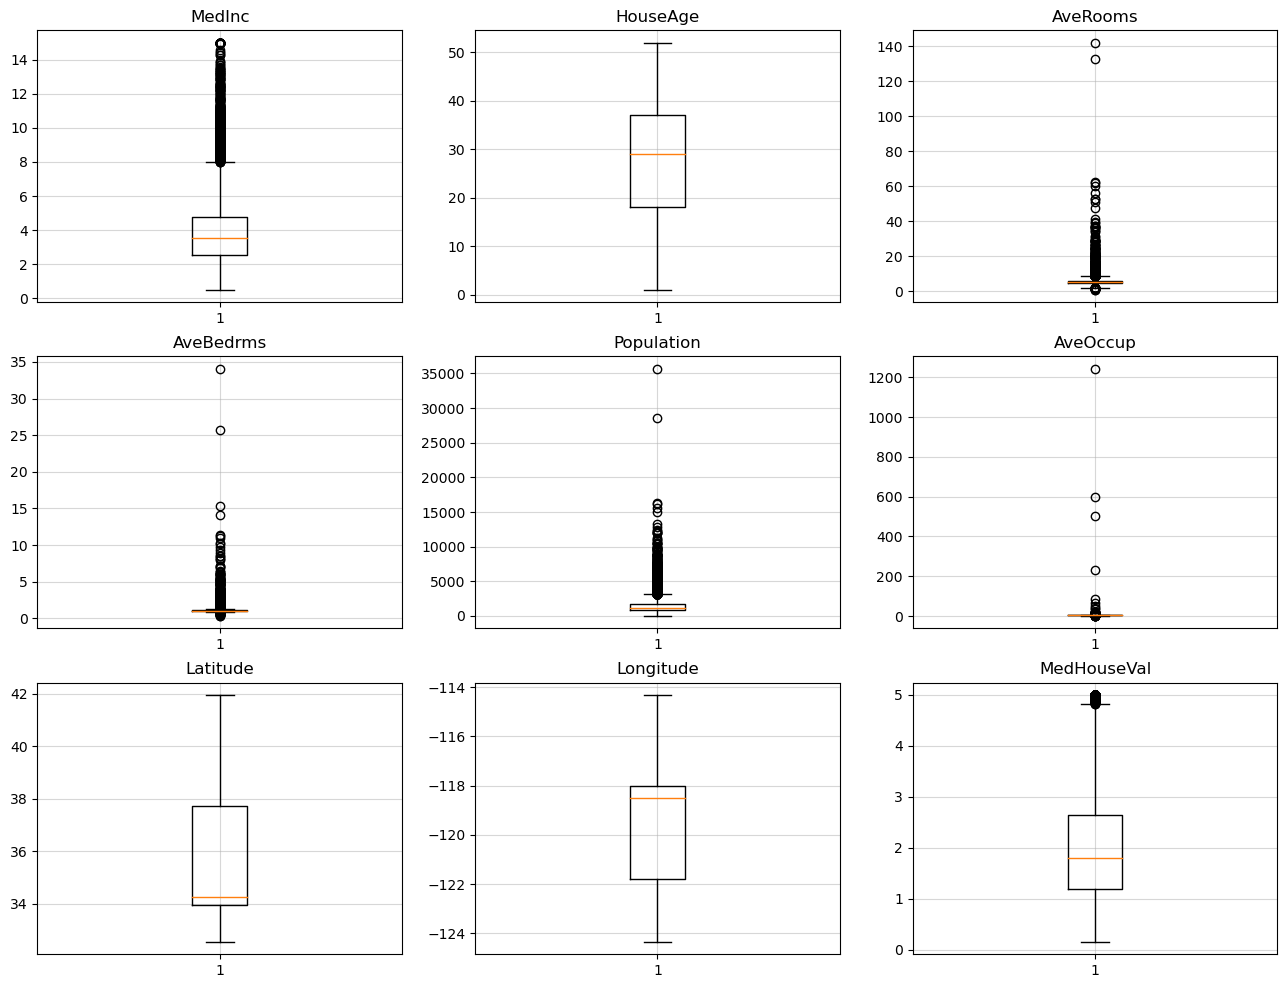

In [8]:
plt.figure(figsize=(16, 12))

for i, col in enumerate(df.columns):
    plt.subplot(3, 3, i + 1)
    plt.boxplot(df[col])
    plt.title(col)
    plt.grid(alpha=.5)

Признаки `MedInc`, `AveRooms`, `AveBedrms`, `Population` и `AveOccup`, а также целевой признак `MedHouseVal` имеют выбросы.

Корреляционная матрица:

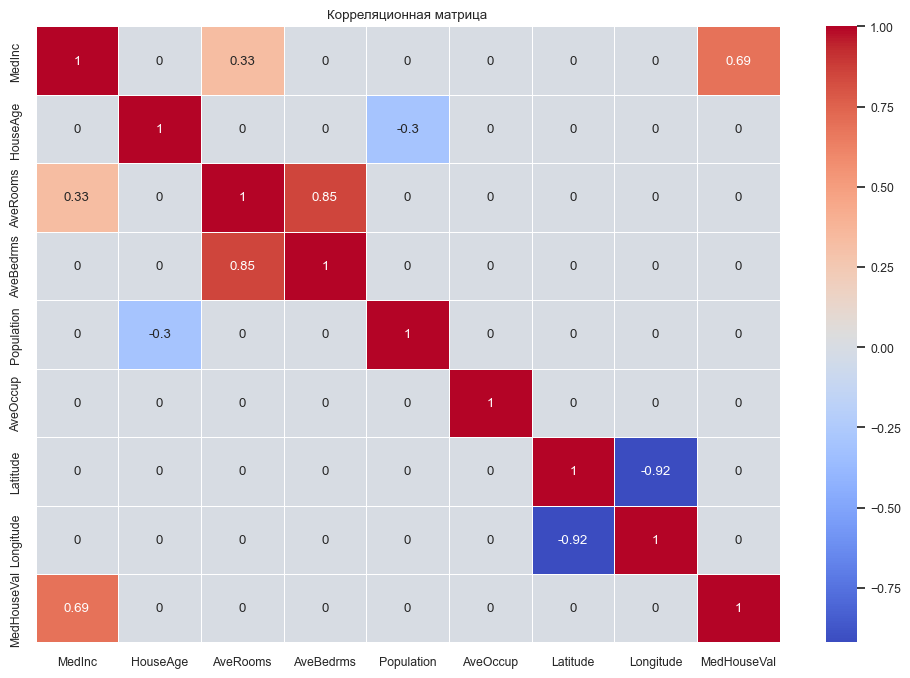

In [9]:
corr_matrix = df.corr()
corr_matrix = np.round(corr_matrix, 2)
corr_matrix[np.abs(corr_matrix) < 0.2] = 0

plt.figure(figsize=(12, 8))
sns.set(font_scale=0.8)
sns.heatmap(corr_matrix, annot=True, linewidths=.5, cmap='coolwarm')

plt.title('Корреляционная матрица')
plt.show();

Корреляционная матрица показала, что целевой признак `MedHouseVal` сильно коррелирует с признаком `MedInc`

# 2. Базовое решение

In [43]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

X_train, X_test, y_train, y_test = train_test_split(df.drop('MedHouseVal', axis=1)
                                                    , df['MedHouseVal']
                                                    , test_size=.2
                                                    , random_state=42)

# scaler = MinMaxScaler().fit(X_train)
# X_train = scaler.transform(X_train)
# X_test = scaler.transform(X_test)

In [31]:
from tensorflow.keras.layers import InputLayer, Dense
from tensorflow.keras.models import Sequential

In [47]:
tf.random.set_seed(42)

base_model = Sequential([
    InputLayer(input_shape=X_train.shape[1],),
    Dense(15, activation='relu'),
    Dense(1),
]
)

base_model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_14 (Dense)            (None, 15)                135       
                                                                 
 dense_15 (Dense)            (None, 1)                 16        
                                                                 
Total params: 151
Trainable params: 151
Non-trainable params: 0
_________________________________________________________________


In [54]:
from tensorflow.keras.losses import mean_absolute_error, mean_squared_error
from tensorflow.keras.optimizers import Adam, SGD

base_model.compile(optimizer=SGD(),
                   loss=mean_squared_error,
                   metrics=['mae'])

In [57]:
history = base_model.fit(X_train, y_train,
               epochs=10,
               validation_data=(X_test, y_test)
               )

Epoch 1/10
  1/516 [..............................] - ETA: 4s - loss: 1.1977 - mae: 0.8896

516/516 [==============================] - 2s 4ms/step - loss: 1.3373 - mae: 0.9131 - val_loss: 1.3132 - val_mae: 0.9140
Epoch 2/10
516/516 [==============================] - 1s 3ms/step - loss: 1.3374 - mae: 0.9146 - val_loss: 1.3109 - val_mae: 0.9079
Epoch 3/10
516/516 [==============================] - 1s 3ms/step - loss: 1.3372 - mae: 0.9143 - val_loss: 1.3102 - val_mae: 0.9037
Epoch 4/10
516/516 [==============================] - 1s 2ms/step - loss: 1.3371 - mae: 0.9144 - val_loss: 1.3102 - val_mae: 0.9018
Epoch 5/10
516/516 [==============================] - 2s 3ms/step - loss: 1.3369 - mae: 0.9145 - val_loss: 1.3112 - val_mae: 0.8967
Epoch 6/10
516/516 [==============================] - 2s 3ms/step - loss: 1.3374 - mae: 0.9131 - val_loss: 1.3107 - val_mae: 0.9072
Epoch 7/10
516/516 [==============================] - 2s 3ms/step - loss: 1.3374 - mae: 0.9143 - val_loss: 1.3104 - val_mae: 0.9059
Epoch 8/10
516/516 [==============================] - 1s 3ms/step - loss: 1.3374 - mae:

In [65]:
loss, metric = base_model.evaluate(X_test, y_test)
print(loss, metric)

129/129 [==============================] - 0s 2ms/step - loss: 1.3107 - mae: 0.9068
1.3106708526611328 0.90680330991745


In [66]:
from sklearn.metrics import r2_score

preds = base_model.predict(X_test)
r2_score(y_test, preds)

129/129 [==============================] - 0s 2ms/step


-0.00019983151568592206